In [37]:
# Import packages
import pandas as pd
import requests as req
import numpy as np
import datetime as dt
import time
import multiprocessing as mp
import os
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as statsmodels
import pickle
np.random.seed(1)
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree
import shap
import sklearn.metrics as metrics
from collections import Counter
from lime import lime_tabular

In [153]:
# Import data
df = pd.read_pickle('feature selection/multi-class-final7.pkl')

In [152]:
# Remove remaining features that cause leakage.
df[['Anomaly_nr','minimum_container_memory_usage_bytes#amd64#e2-custom-8-12288#linux#pd-standard#docker#default-pool#cos#e2#europe-west3#europe-west3-a#/#gke-made-default-pool-e1ed2951-hgtl#kubernetes-cadvisor#amd64#gke-made-default-pool-e1ed2951-hgtl#linux#e2-custom-8-12288#5#europe-west3-a#europe-west3#europe-west3-a']].to_csv('feature selection/visual-thesis.csv')

In [154]:
df.shape

(17054, 4227)

In [155]:
# Split data into stratified train/test sets

x, x_test, y, y_test = train_test_split(df.drop(['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] + [column for column in df.columns if 'scrape_series_added' in column] + [column for column in df.columns if 'prometheus_sd_kubernetes_events' in column] + [column for column in df.columns if 'goroutines' in column] , axis=1), df['Anomaly_nr'], test_size=0.2, train_size=0.8, random_state=1, stratify=df['Anomaly_nr'])

In [156]:
x_test.shape

(3411, 3972)

# Decision Tree

In [4]:
# This functions runs Random Forest models using different parameters from the random_grid. 
# Results are saved in a dataframe and returned.
def runDecisionTree(df, max_features, max_depth, min_samples_split, min_samples_leaf, n_iter, test_size, train_size):
    
    #Different parameters are initialized.
    random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    # Random Forest Classifier model is initialized.
    DTClassifierModel = DecisionTreeClassifier() 
    
    # Randomized Search is being used with different parameters (from random_grid).
    dt_random = RandomizedSearchCV(estimator = DTClassifierModel, param_distributions = random_grid, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'], n_iter = n_iter, cv = 10, verbose=2, random_state=1, n_jobs = -1, refit='accuracy', return_train_score = True)
    
    # Split data into stratified train/test sets

    x, x_test, y, y_test = train_test_split(df.drop(['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] , axis=1), df['Anomaly_nr'], test_size=0.2, train_size=0.8, random_state=1, stratify=df['Anomaly_nr'])
    #Model is fitted with the x and y data.
    dt_random.fit(x, y)

    #Results are assigned to a new dataframe and shown.
    dfResult = pd.DataFrame(dt_random.cv_results_)
    
    return dfResult, dt_random

In [5]:
# Running decision tree models with different parameters.
# Results are stored in a DataFrame.

max_features = np.linspace(0,1,11,endpoint=True)[1:]
max_depth = range(10, 101) 
min_samples_split = range(2, 31)
min_samples_leaf = range(1, 21)



dfResults, dt_model = runDecisionTree(df, max_features, max_depth, min_samples_split, min_samples_leaf, 1, 0.2, 0.8)        

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [13]:
# Rank results 
dfResults['Ranking'] = dfResults['mean_test_accuracy'].rank(method='max', ascending=False)

dfResults = dfResults[['Ranking', 'mean_train_accuracy', 'mean_test_accuracy', 'mean_test_f1_macro', 'f1_weighted', 'mean_test_precision_macro', 'mean_test_recall_macro','param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'mean_fit_time', 'mean_score_time']].sort_values(by='mean_test_accuracy', ascending=False)
dfResults.set_index('Ranking', inplace=True)

# Save model and results in pickle file
with open('models/decision_tree/models/best_decision_tree.pkl', 'wb') as fid:
    pickle.dump(dt_model.best_estimator_, fid)  

dfResults.to_pickle('models/decision_tree/results/results_final.pkl')
dfResults

mean_train_accuracy  mean_test_accuracy  mean_test_f1_macro  \
Ranking                                                                
1.0                 0.997044            0.973466            0.973230   
2.0                 1.000000            0.973392            0.973067   
3.0                 0.989730            0.965989            0.965821   
4.0                 0.984909            0.965183            0.964691   
5.0                 0.984754            0.964817            0.964319   
...                      ...                 ...                 ...   
96.0                0.944188            0.922598            0.921894   
97.0                0.934146            0.919080            0.918875   
98.0                0.891202            0.878473            0.874849   
99.0                0.862966            0.847467            0.849425   
100.0               0.825388            0.812876            0.815991   

         mean_test_f1_weighted  mean_test_precision_macro  \
Ranking                                                     
1.0                   0.973437                   0.973179   
2.0                   0.973364                   0.973101   
3.0                   0.965946                   0.965864   
4.0                   0.965158                   0.964540   
5.0                   0.964804                   0.964188   
...                        ...                        ...   
96.0                  0.922554                   0.922216   
97.0                  0.919737                   0.921246   
98.0                  0.877098                   0.899403   
99.0                  0.850442                   0.866478   
100.0                 0.816397                   0.855195   

         mean_test_recall_macro param_min_samples_split  \
Ranking                                                   
1.0                    0.973461                       5   
2.0                    0.973191                       2   
3.0                    0.966033                      12   
4.0                    0.965127                       8   
5.0                    0.964814                      16   
...                         ...                     ...   
96.0                   0.922699                      13   
97.0                   0.919154                      11   
98.0                   0.871968                      24   
99.0                   0.847944                       4   
100.0                  0.815369                      13   

        param_min_samples_leaf param_max_features param_max_depth  \
Ranking                                                             
1.0                          1                0.8              94   
2.0                          1                0.6              98   
3.0                          1                0.6              73   
4.0                          5                  1              46   
5.0                          2                0.8              60   
...                        ...                ...             ...   
96.0                        17                0.1              44   
97.0                        20                0.7              13   
98.0                         2                  1              10   
99.0                        17                0.2              10   
100.0                        9                0.1              10   

         mean_fit_time  mean_score_time  
Ranking                                  
1.0          43.587017         0.075960  
2.0          33.780390         0.072799  
3.0          30.913233         0.045402  
4.0          52.986194         0.072521  
5.0          43.260321         0.072364  
...                ...              ...  
96.0          6.044174         0.074071  
97.0         31.471212         0.074007  
98.0         43.102757         0.072911  
99.0          9.109113         0.075391  
100.0         4.888114         0.072503  

[100 rows x 12 columns]

In [14]:
# Load results
dfResults = pd.read_pickle('models/decision_tree/results/results_final.pkl')\

# Load best decision tree
with open('models/decision_tree/models/best_decision_tree.pkl', 'rb') as fid:
    dt_model = pickle.load(fid)

In [64]:
print(metrics.classification_report(dt_model.predict(x_test), y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       429
         1.0       0.98      0.98      0.98       523
         2.0       0.98      0.96      0.97       542
         3.0       0.96      0.97      0.97       393
         4.0       0.99      0.98      0.98       538
         5.0       0.97      0.97      0.97       471
         6.0       0.94      0.95      0.94       515

    accuracy                           0.97      3411
   macro avg       0.97      0.97      0.97      3411
weighted avg       0.97      0.97      0.97      3411



In [8]:
pd.read_pickle('models/decision_tree/results/results_final.pkl')

mean_train_accuracy  mean_test_accuracy  mean_test_f1_macro  \
Ranking                                                                
1.0                 1.000000            0.972293            0.972297   
2.0                 0.995732            0.968262            0.967861   
3.0                 0.983044            0.959099            0.958686   
4.0                 0.977384            0.956461            0.956343   
5.0                 0.970917            0.952063            0.951380   
6.0                 0.967814            0.951109            0.950614   
7.0                 0.970054            0.951037            0.950482   
8.0                 0.971952            0.949936            0.949684   
9.0                 0.966617            0.949203            0.948973   
10.0                0.968783            0.948690            0.948350   
11.0                0.963490            0.948618            0.948460   
12.0                0.973434            0.948470            0.948410   
13.0                0.970657            0.948398            0.948120   
14.0                0.964605            0.946273            0.946083   
15.0                0.964540            0.946126            0.945863   
16.0                0.963286            0.945612            0.945244   
17.0                0.967554            0.944954            0.944617   
18.0                0.959817            0.944734            0.944408   
19.0                0.962781            0.944661            0.944347   
20.0                0.960037            0.943854            0.943315   
21.0                0.958913            0.943706            0.943317   
22.0                0.961331            0.942974            0.942646   
23.0                0.954564            0.942021            0.941491   
24.0                0.959043            0.940408            0.939926   
25.0                0.954050            0.939529            0.939120   
26.0                0.960713            0.939455            0.939109   
27.0                0.961120            0.937697            0.937172   
28.0                0.959320            0.937183            0.936959   
29.0                0.953073            0.937111            0.936635   
30.0                0.954767            0.936377            0.936206   
31.0                0.951135            0.935791            0.935123   
32.0                0.950671            0.935644            0.934689   
33.0                0.954181            0.935643            0.935426   
34.0                0.947446            0.934691            0.933944   
35.0                0.949807            0.932784            0.931676   
36.0                0.946542            0.932199            0.931339   
37.0                0.950434            0.930954            0.930483   
38.0                0.943789            0.930367            0.929720   
39.0                0.950035            0.930220            0.929715   
40.0                0.943015            0.928827            0.928015   
41.0                0.943610            0.928168            0.927542   
42.0                0.949441            0.923403            0.924066   
43.0                0.940018            0.922670            0.922120   
44.0                0.938121            0.920910            0.920467   
45.0                0.938935            0.920764            0.920095   
46.0                0.853934            0.835300            0.842905   
47.0                0.841058            0.830534            0.836724   
48.0                0.812342            0.801803            0.812523   
49.0                0.806535            0.796523            0.804143   
50.0                0.707591            0.694572            0.697431   

         mean_test_precision_macro  mean_test_recall_macro  \
Ranking                                                      
1.0                       0.972451                0.972312   
2.0                       0.967795                0.968143   
3.0             

# Random Forest

In [64]:
# This functions runs Random Forest models using different parameters from the random_grid. 
# Results are saved in a dataframe and returned.
def runRandomForest(df, n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, n_iter, test_size, train_size):
    
    #Different parameters are initialized.
    random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    # Random Forest Classifier model is initialized.
    RFClassifierModel = RandomForestClassifier() 
    
    # Randomized Search is being used with different parameters (from random_grid).
    rf_random = RandomizedSearchCV(estimator = RFClassifierModel, param_distributions = random_grid, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'], n_iter = n_iter, cv = 10, verbose=2, random_state=1, n_jobs = -1, refit='accuracy', return_train_score = True)
    
   # Split data into stratified train/test sets

    x, x_test, y, y_test = train_test_split(df.drop(['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] , axis=1), df['Anomaly_nr'], test_size=0.2, train_size=0.8, random_state=1, stratify=df['Anomaly_nr'])
    #Model is fitted with the x and y data.
    rf_random.fit(x, y)
    
    #Results are assigned to a new dataframe and shown.
    dfResult = pd.DataFrame(rf_random.cv_results_)
    
    return dfResult, rf_random

In [70]:
# Running Random Forest models with different parameters.
# Results are stored in a DataFrame.

n_estimators = range(10, 101, 10)
max_features = np.linspace(0,1,11,endpoint=True)[1:]
max_depth = range(10, 101) 
min_samples_split = range(2, 21)
min_samples_leaf = range(1, 11)



dfResults, rf_model = runRandomForest(df, n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, 20, 0.2, 0.8)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [9]:
pd.read_pickle('models/random_forest/results/results_final.pkl')

mean_train_accuracy  mean_test_accuracy  mean_test_f1_macro  \
Ranking                                                                
1.0                 0.996547            0.988858            0.988768   
2.0                 0.996710            0.986220            0.986131   
3.0                 0.996099            0.986073            0.985934   
4.0                 0.994405            0.985927            0.985849   
5.0                 0.990846            0.985048            0.984971   
6.0                 0.990129            0.983288            0.983148   
7.0                 0.995350            0.983141            0.983105   
8.0                 0.992467            0.982555            0.982351   
9.0                 0.991107            0.981602            0.981393   
10.0                0.989624            0.980649            0.980546   
11.0                0.988940            0.979696            0.979551   
12.0                0.988842            0.979550            0.979423   
13.0                0.986546            0.978083            0.977925   
14.0                0.987059            0.978011            0.977916   
15.0                0.986082            0.977864            0.977742   
16.0                0.986350            0.977644            0.977493   
17.0                0.985674            0.977277            0.977169   
18.0                0.983940            0.975445            0.975310   
19.0                0.940059            0.927801            0.928817   
20.0                0.873993            0.865132            0.872752   

         mean_test_precision_macro  mean_test_recall_macro param_n_estimators  \
Ranking                                                                         
1.0                       0.988538                0.989234                100   
2.0                       0.985895                0.986575                 10   
3.0                       0.985676                0.986429                 70   
4.0                       0.985641                0.986300                 50   
5.0                       0.984756                0.985483                100   
6.0                       0.982964                0.983676                100   
7.0                       0.982948                0.983538                 70   
8.0                       0.982109                0.982871                 90   
9.0                       0.981127                0.981957                 40   
10.0                      0.980400                0.981061                 40   
11.0                      0.979374                0.980097                 20   
12.0                      0.979072                0.980209                 10   
13.0                      0.977732                0.978564                 50   
14.0                      0.977748                0.978503                 50   
15.0                      0.977561                0.978324                 60   
16.0                      0.977323                0.978115                 60   
17.0                      0.976991                0.977788                 60   
18.0                      0.975050                0.976013                 90   
19.0                      0.936259                0.929317                 80   
20.0                      0.907862                0.867470                100   

        param_min_samples_split param_min_samples_leaf param_max_features  \
Ranking                                                                     
1.0                          12                      3                0.1   
2.0                          13                      2                0.1   
3.0                          14                      2                0.4   
4.0                           8                      4                0.4   
5.0                          14                      9                0.2   
6.0                          14                      8                0.4   
7.0                      

In [ ]:
# Ranking models
dfResults['Ranking'] = dfResults['mean_test_accuracy'].rank(method='max', ascending=False)

dfResults = dfResults[['Ranking', 'mean_train_accuracy', 'mean_test_accuracy', 'mean_test_f1_macro', 'f1_weighted', 'mean_test_precision_macro', 'mean_test_recall_macro', 'param_n_estimators', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'mean_fit_time', 'mean_score_time']].sort_values(by='mean_test_accuracy', ascending=False)
dfResults.set_index('Ranking', inplace=True)

# Save model and results in pickle file
with open('models/random_forest/models/best_random_forest.pkl', 'wb') as fid:
    pickle.dump(rf_model.best_estimator_, fid)  

dfResults.to_pickle('models/random_forest/results/results_final.pkl')
dfResults

In [9]:
with open('models/random_forest/models/best_random_forest.pkl', 'rb') as fid:
    rf_model = pickle.load(fid)

# Adaboost on worst Decision Tree

In [11]:
# This functions runs Random Forest models using different parameters from the random_grid. 
# Results are saved in a dataframe and returned.
def runAdaBoost(df, base_estimator, nr_estimators, learning_rate, n_iter, test_size, train_size):
    
    #Different parameters are initialized.
    random_grid = {'n_estimators': nr_estimators,
               'learning_rate': learning_rate}
    
    # Random Forest Classifier model is initialized.
    ada_model = AdaBoostClassifier(base_estimator) 
    
    # Randomized Search is being used with different parameters (from random_grid).
    dt_random = RandomizedSearchCV(estimator = ada_model, param_distributions = random_grid, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'], n_iter = n_iter, cv = 10, verbose=2, random_state=1, n_jobs = -1, refit='accuracy', return_train_score = True)
    
   # Split data into stratified train/test sets

    x, x_test, y, y_test = train_test_split(df.drop(['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] + [column for column in df.columns if 'scrape_series_added' in column] + [column for column in df.columns if 'prometheus_sd_kubernetes_events' in column] + [column for column in df.columns if 'goroutines' in column] , axis=1), df['Anomaly_nr'], test_size=0.2, train_size=0.8, random_state=1, stratify=df['Anomaly_nr'])
    #Model is fitted with the x and y data.
    dt_random.fit(x, y)

    #Results are assigned to a new dataframe and shown.
    dfResult = pd.DataFrame(dt_random.cv_results_)
    
    return dfResult, dt_random

In [ ]:
# Running Adaboost models with different parameters.
# Results are stored in a DataFrame.
nr_estimators = range(40, 111, 10)
learning_rate = np.linspace(0.2,1, 11,endpoint=True)

dt_model = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=17, max_features=0.2, max_depth=10)



dfResults, ada_model = runAdaBoost(df, dt_model, nr_estimators, learning_rate, 1, 0.2, 0.8)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [ ]:
# Rank models
dfResults['Ranking'] = dfResults['mean_test_accuracy'].rank(method='max', ascending=False)

dfResults = dfResults[['Ranking', 'mean_train_accuracy', 'mean_test_accuracy', 'mean_test_f1_macro', 'f1_weighted', 'mean_test_precision_macro', 'mean_test_recall_macro','param_learning_rate', 'param_n_estimators', 'mean_fit_time', 'mean_score_time']].sort_values(by='mean_test_accuracy', ascending=False)
dfResults.set_index('Ranking', inplace=True)

# Save model and results in pickle file
with open('models/adaboost/models/best_dt_adaboost.pkl', 'wb') as fid:
    pickle.dump(ada_model.best_estimator_, fid)  

dfResults.to_pickle('models/adaboost/results/results_final_ada_dt.pkl')
dfResults

In [8]:
with open('models/adaboost/models/best_dt_adaboost.pkl', 'rb') as fid:
    ada_model = pickle.load(fid)

In [10]:
pd.read_pickle('models/adaboost/results/results_final_ada_dt.pkl')

mean_train_accuracy  mean_test_accuracy  mean_test_f1_macro  \
Ranking                                                                
1.0                      1.0            0.991351            0.991276   
2.0                      1.0            0.991351            0.991334   
3.0                      1.0            0.990618            0.990603   
4.0                      1.0            0.990471            0.990420   
5.0                      1.0            0.990324            0.990278   
6.0                      1.0            0.990251            0.990246   
7.0                      1.0            0.990105            0.990142   
8.0                      1.0            0.990031            0.990025   
9.0                      1.0            0.990031            0.989910   
10.0                     1.0            0.989958            0.989903   
11.0                     1.0            0.989811            0.989823   
13.0                     1.0            0.989811            0.989818   
13.0                     1.0            0.989811            0.989786   
14.0                     1.0            0.989738            0.989651   
15.0                     1.0            0.989518            0.989452   
16.0                     1.0            0.989445            0.989395   
17.0                     1.0            0.989225            0.989267   
18.0                     1.0            0.989078            0.989074   
19.0                     1.0            0.989005            0.989038   
20.0                     1.0            0.988712            0.988657   

         mean_test_precision_macro  mean_test_recall_macro  \
Ranking                                                      
1.0                       0.991201                0.991447   
2.0                       0.991320                0.991427   
3.0                       0.990531                0.990772   
4.0                       0.990356                0.990569   
5.0                       0.990277                0.990378   
6.0                       0.990141                0.990468   
7.0                       0.990108                0.990287   
8.0                       0.989968                0.990197   
9.0                       0.989896                0.990030   
10.0                      0.989825                0.990078   
11.0                      0.989694                0.990059   
13.0                      0.989748                0.989983   
13.0                      0.989725                0.989965   
14.0                      0.989539                0.989903   
15.0                      0.989346                0.989681   
16.0                      0.989339                0.989606   
17.0                      0.989188                0.989490   
18.0                      0.988954                0.989324   
19.0                      0.988947                0.989271   
20.0                      0.988563                0.988848   

        param_learning_rate param_n_estimators  mean_fit_time  mean_score_time  
Ranking                                                                         
1.0                0.236181                 85     989.202390         1.783720  
2.0                0.521608                 50     523.778516         0.996864  
3.0                0.545729                 90     939.329363         1.841674  
4.0                0.939698                 55     694.924244         1.324208  
5.0                0.441206                 65     735.297669         1.950954  
6.0                0.883417                 70     735.283199         1.462847  
7.0                0.493467                 45     491.540090         1.069882  
8.0                 0.99196                 75     782.742783         1.444809  
9.0                0.457286                 40     560.963044         1.151807  
10.0               0.260302                 90     986.029360         2.069294  
11.0               0.947739                 75     789.979543         1.607660  
13.0  

# Visuals

In [11]:
# Function to get all evaluation metrics.
def get_evaluation_metrics(model, x_test, y_test, model_name):
    
    model_results = []
    model_results.append(model_name)
    y_pred = model.predict(x_test)
    model_results.append(metrics.accuracy_score(y_test, y_pred))
    model_results.append(metrics.recall_score(y_test, y_pred, average='macro'))
    model_results.append(metrics.precision_score(y_test, y_pred, average='macro'))
    model_results.append(metrics.fbeta_score(y_test, y_pred, average='macro', beta=0.5))
    model_results.append(metrics.f1_score(y_test, y_pred, average='weighted'))
    model_results = [model_results]
    return pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F-Score', 'Weighted F-Score'])

# Save confusion matrix for each class. 
def save_confusion_matrix(file_name, model, x_test, y_test):

    sns.set(rc={'figure.figsize':(16.7,8.27)})

    fig, ax = plt.subplots(figsize=(16, 9))

    sns_plot = sns.heatmap(confusion_matrix(y_test, model.predict(x_test)), annot=True, cmap='Blues', fmt='g', xticklabels=['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], yticklabels=['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], linewidth=0.5)

    plt.xlabel('Predicted label', size=15)
    plt.ylabel('True label', size=15)

    sns_plot.figure.savefig('visuals/' + file_name,dpi=200)
    plt.show()

In [12]:
# Save confusion matrix anomalous vs non-anomalous.
def save_general_confusion_matrix(file_name, model, x_test, y_test):
    anomaly_check = []
    predictions = model.predict(x_test)
    anomaly_predicted = []
    for i in range(0, len(x_test)):
        if y_test[i] == 6:
            anomaly_check.append(0)
        else:
            anomaly_check.append(1)
        
        if predictions[i] == 6:
            anomaly_predicted.append(0)
        else:
            anomaly_predicted.append(1)
    
    fig, ax = plt.subplots(figsize=(16, 9))
    sns_plot = sns.heatmap(metrics.confusion_matrix(anomaly_check, anomaly_predicted), annot=True, cmap='Blues', fmt='g', xticklabels=['Non-Anomalous', 'Anomalous'], yticklabels=['Non-Anomalous', 'Anomalous'])
    plt.xlabel('Predicted label', size=15)
    plt.ylabel('True label', size=15)
    
    sns_plot.figure.savefig('visuals/' + file_name, dpi=200)
    plt.show()
    

In [134]:
# Get accuracies for each model.
def get_accuracies():
    
    models = ['Decision Tree', 'Random Forest', 'AdaBoost']
    file_results = ['models/decision_tree/results/results_final.pkl', 'models/random_forest/results/results_final.pkl', 'models/adaboost/results/results_final_ada_dt.pkl']
    model_files = ['models/decision_tree/models/best_decision_tree.pkl', 'models/random_forest/models/best_random_forest.pkl', 'models/adaboost/models/best_dt_adaboost.pkl']
    df = pd.DataFrame(columns=['Model', 'Train', 'Test', 'Validation'])
    for i in range(0, len(file_results)):
        data = pd.read_pickle(file_results[i])
        with open(model_files[i], 'rb') as fid:
            model = pickle.load(fid)
        
        y_pred = model.predict(x_test)

        df = df.append({'Model': models[i], 'Train' : data.iloc[0]['mean_train_accuracy'], 'Test' : data.iloc[0]['mean_test_accuracy'], 'Validation' : metrics.accuracy_score(y_test, y_pred)}, ignore_index=True)
               
    
    return df
    

In [137]:
# Get accuracies for each model for train, test, and train set.
df_accuracies = get_accuracies()
df_accuracies.melt(id_vars=['Model'], var_name='Metric', value_name='Accuracy')

Model      Metric  Accuracy
0  Decision Tree       Train  1.000000
1  Random Forest       Train  0.996547
2       AdaBoost       Train  1.000000
3  Decision Tree        Test  0.972293
4  Random Forest        Test  0.988858
5       AdaBoost        Test  0.991351
6  Decision Tree  Validation  0.975374
7  Random Forest  Validation  0.988273
8       AdaBoost  Validation  0.988273

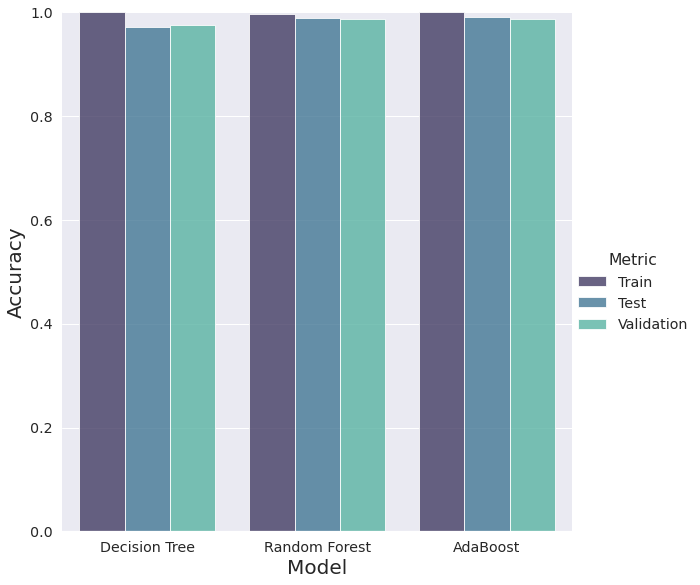

In [140]:
# Generate bar plot for the accuracies.

df_accuracies = get_accuracies()

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth":1.5})

g = sns.catplot(
    data=df_accuracies.melt(id_vars=['Model'], var_name='Metric', value_name='Accuracy'), kind="bar",
    x="Model", y="Accuracy", hue="Metric",
    ci="sd", palette="mako", alpha=.8, height=8, aspect=1
)
g.despine(left=True)
g.set_axis_labels("Model", "Accuracy", size=20)
g.set(ylim=(0, 1))


g.savefig('visuals/ModelAccuracies.png', dpi=200)



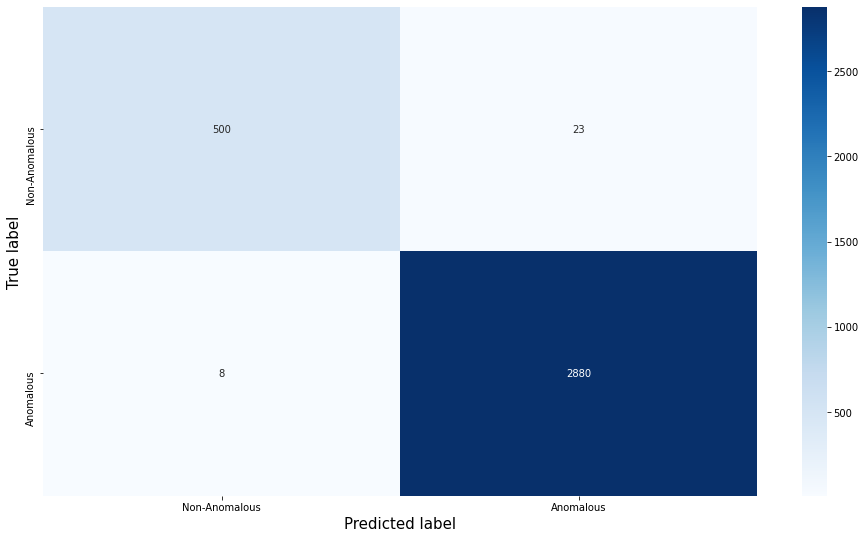

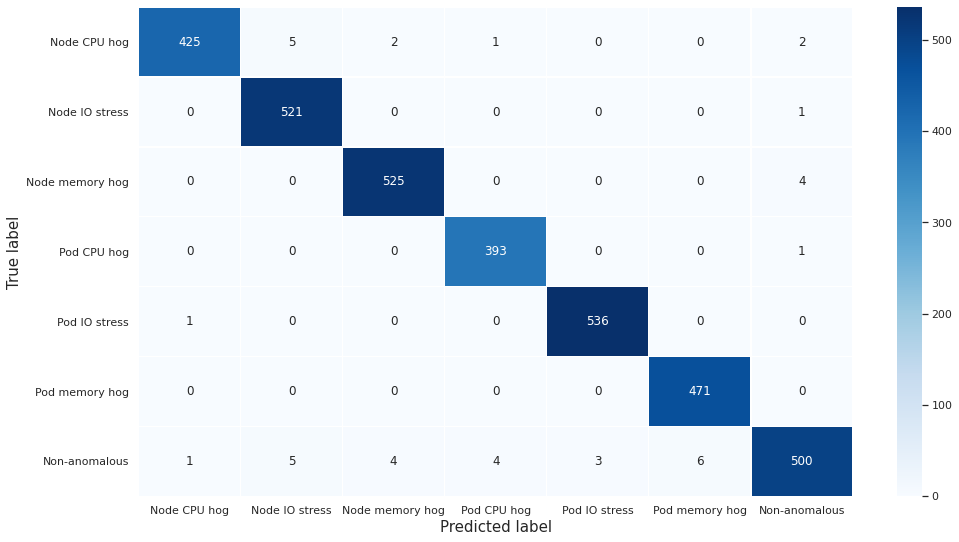

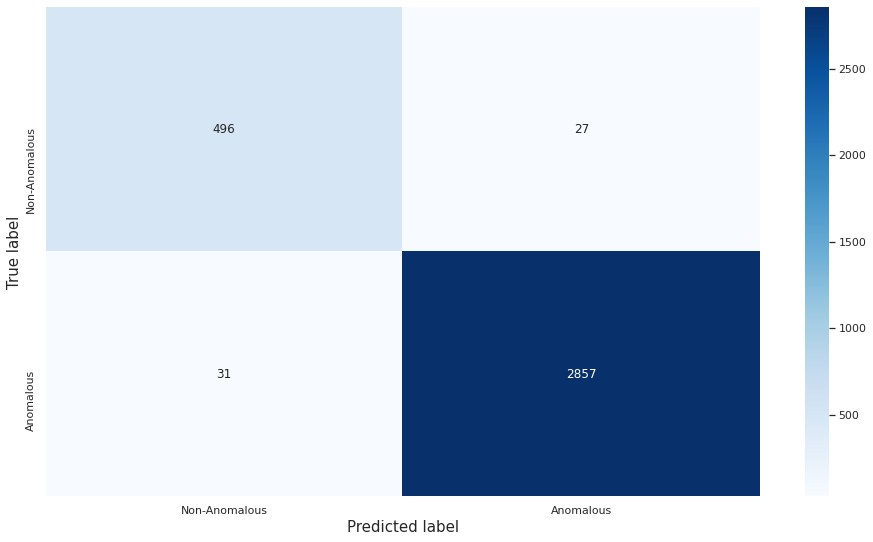

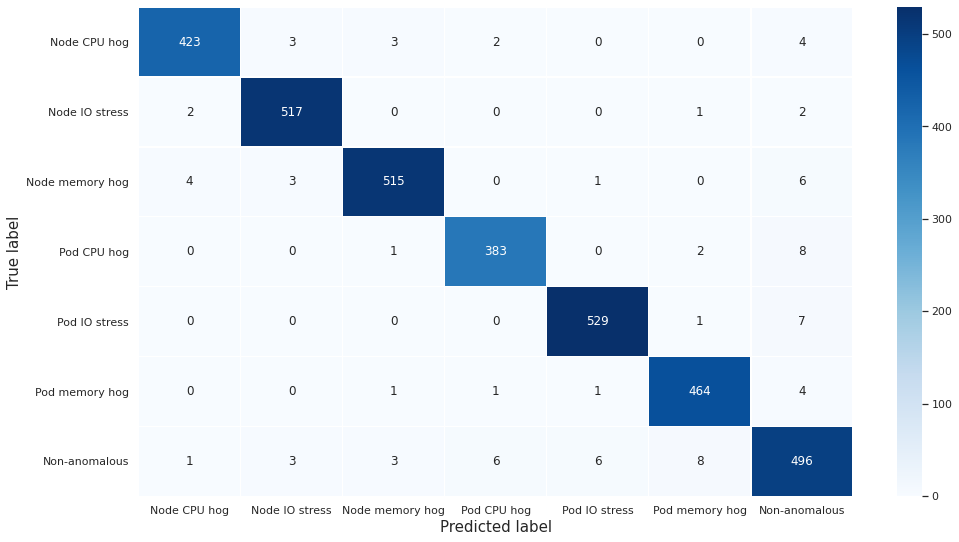

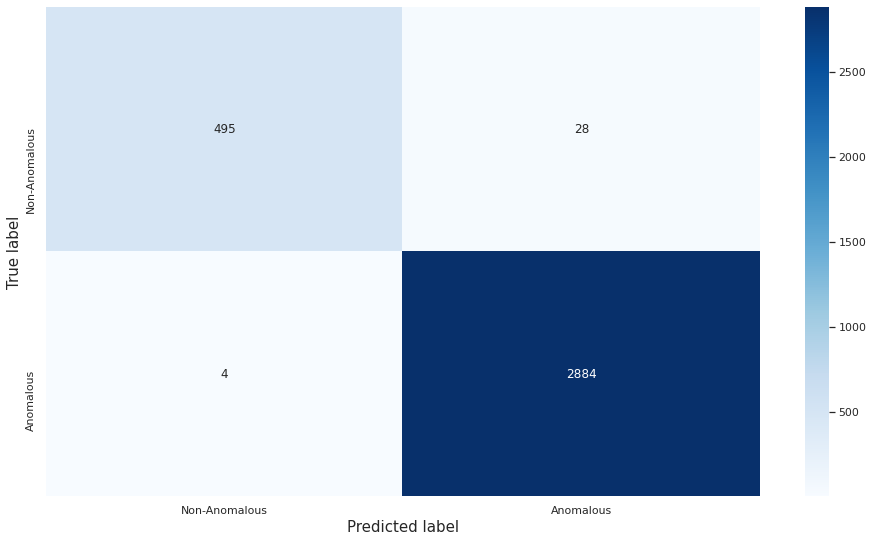

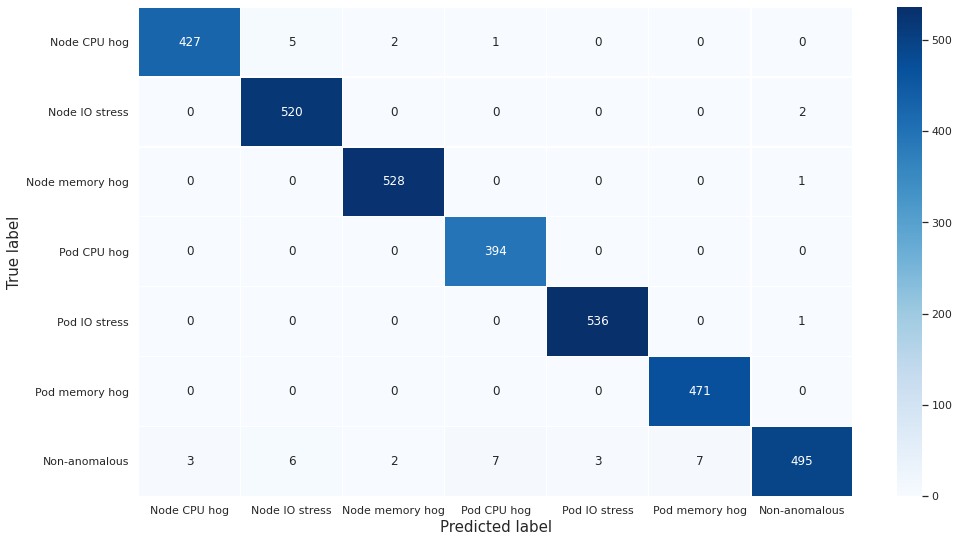

In [13]:
# Generate confusion matrices.

model_names = ['AdaBoost', 'Decision Tree', 'Random Forest']
model_paths = ['models/adaboost/models/best_dt_adaboost.pkl', 'models/decision_tree/models/best_decision_tree.pkl', 'models/random_forest/models/best_random_forest.pkl']
df_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F-Score', 'Weighted F-Score'])
for i in range(0, len(model_names)):
    with open(model_paths[i], 'rb') as fid:
        model = pickle.load(fid)
    df_metrics = pd.concat([df_metrics, get_evaluation_metrics(model, x_test, y_test, model_names[i])])
    
    save_general_confusion_matrix('GeneralConfusionMatrix' + model_names[i], model, x_test, y_test)
    save_confusion_matrix('ConfusionMatrix' + model_names[i], model, x_test, y_test)
    

In [16]:
# All metrics for each model
df_metrics

Model  Accuracy    Recall  Precision   F-Score  Weighted F-Score
0       AdaBoost  0.988273  0.988451   0.988390  0.988362          0.988218
0  Decision Tree  0.975374  0.975295   0.975632  0.975553          0.975387
0  Random Forest  0.988273  0.988641   0.988095  0.988130          0.988193

In [15]:
# Melt the accuracies for visualization purposes.
df_metrics.melt(id_vars=['Model'], var_name='Metric', value_name='Value')

Model            Metric     Value
0        AdaBoost          Accuracy  0.988273
1   Decision Tree          Accuracy  0.975374
2   Random Forest          Accuracy  0.988273
3        AdaBoost            Recall  0.988451
4   Decision Tree            Recall  0.975295
5   Random Forest            Recall  0.988641
6        AdaBoost         Precision  0.988390
7   Decision Tree         Precision  0.975632
8   Random Forest         Precision  0.988095
9        AdaBoost           F-Score  0.988362
10  Decision Tree           F-Score  0.975553
11  Random Forest           F-Score  0.988130
12       AdaBoost  Weighted F-Score  0.988218
13  Decision Tree  Weighted F-Score  0.975387
14  Random Forest  Weighted F-Score  0.988193

In [49]:
# Save melted df
df_metrics.melt(id_vars=['Model'], var_name='Metric', value_name='Value').to_pickle('Model_results.pkl')

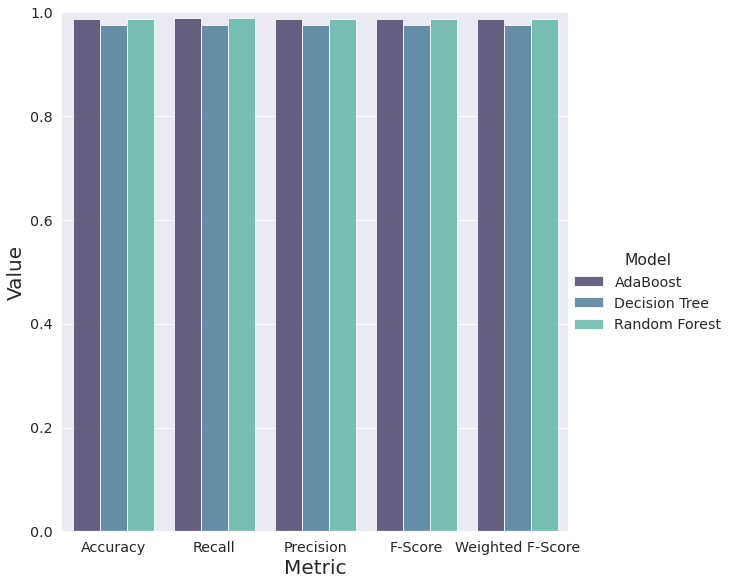

In [14]:
# Bar plot for all metrics for each model
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth":1.5})

g = sns.catplot(
    data=df_metrics.melt(id_vars=['Model'], var_name='Metric', value_name='Value'), kind="bar",
    x="Metric", y="Value", hue="Model",
    ci="sd", palette="mako", alpha=.8, height=8, aspect=1
)
g.despine(left=True)
g.set_axis_labels("Metric", "Value", size=20)
#g.set_xticklabels(size=12)
#g.set_yticklabels(size=12)
g.set(ylim=(0, 1))


g.savefig('visuals/ModelPerformance.png', dpi=200)



## Decision Tree: SHAP

<Figure size 1202.4x595.44 with 0 Axes>

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


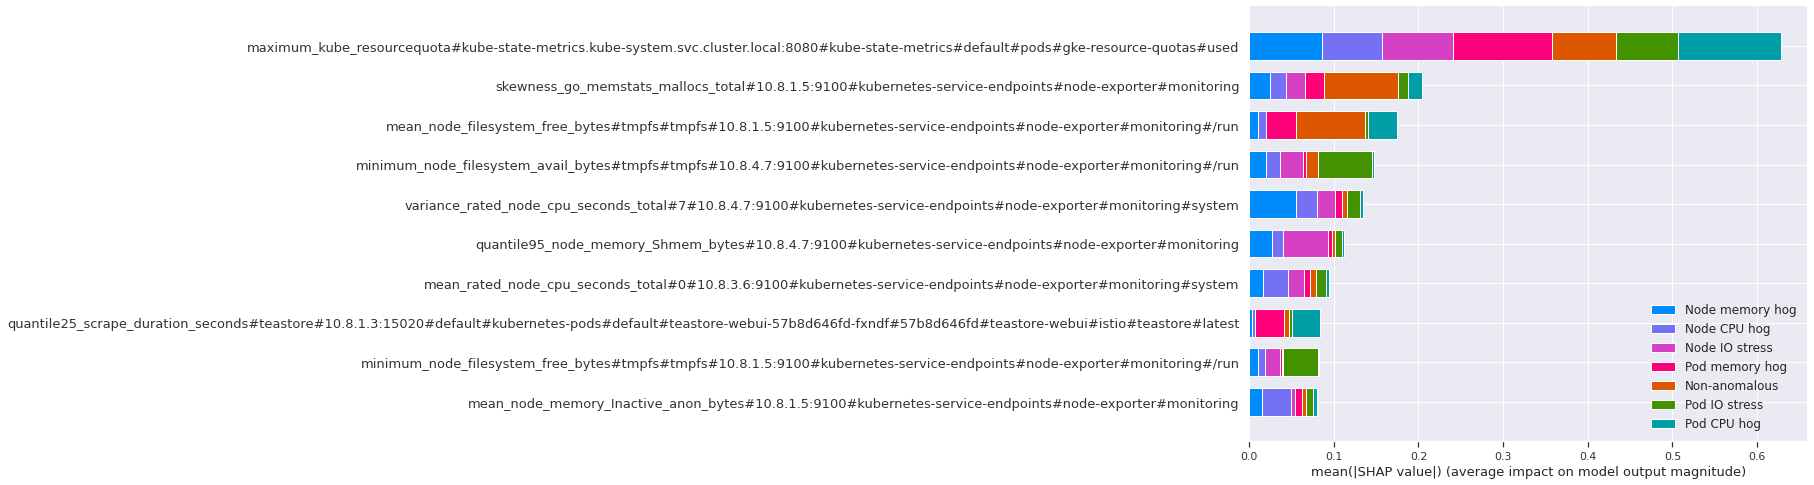

In [74]:
# Load best decision tree
with open('models/decision_tree/models/best_decision_tree.pkl', 'rb') as fid:
    dt_model = pickle.load(fid)

figure = plt.figure()

# Show most important features and their importance to each class/anomaly
shap.initjs()

plt.figure(figsize=(14,8), tight_layout=True)
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(x_test)

df_visual = x_test

shap.summary_plot(shap_values, df_visual, plot_type='bar', class_names = ['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], plot_size = (10, 8), max_display=10)


figure.savefig('visuals/DT_Global_Shap_Fullname.png', dpi=200)

plt.show()



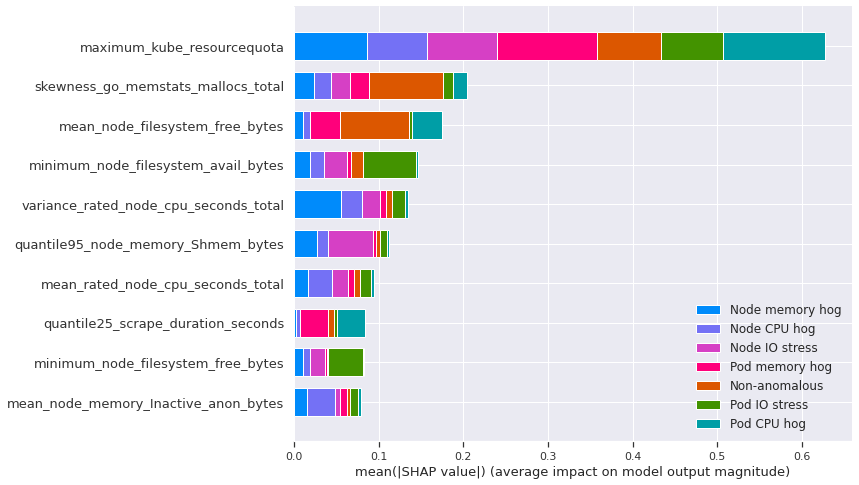

In [75]:
# Top 10 features with short names
df_visual.columns = [column.split('#')[0] for column in x_test.columns]
shap.summary_plot(shap_values, df_visual, plot_type='bar', class_names = ['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], plot_size = (10, 8), max_display=10)
figure.savefig('visuals/DT_Global_Shap_Shortname.png', dpi=200)

In [21]:
shap.summary_plot

<function shap.plots._beeswarm.summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f76668be588>, auto_size_plot=None, use_log_scale=False)>

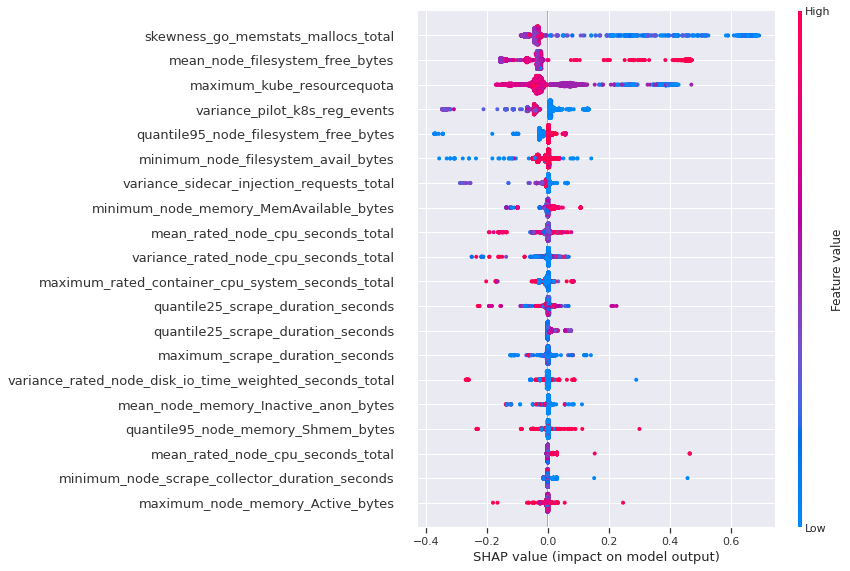

In [93]:
# Global for 1 class.

shap.summary_plot(shap_values[6], df_visual, feature_names = df_visual.columns)

In [94]:
# Generate shap values on test set
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(x_test)

In [28]:
# Local interpretability

shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test.iloc[0], feature_names = x_test.columns)

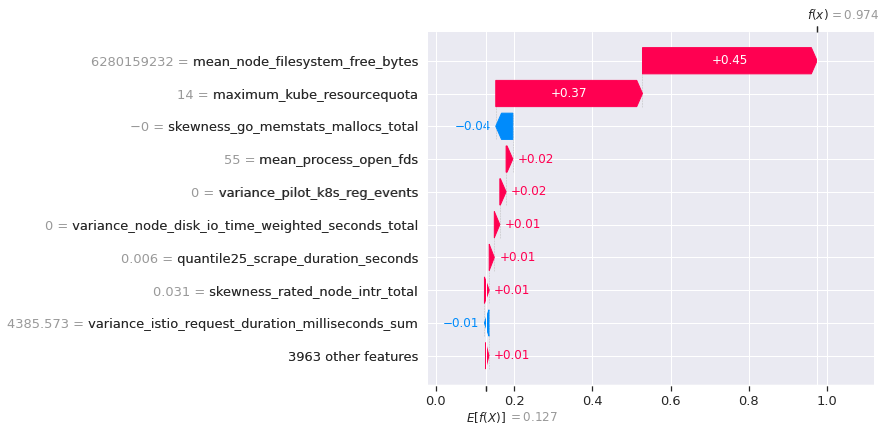

In [109]:
# Local interpretability for class 6 on instance 4.
class_number = 6
row = 4

shap.waterfall_plot(shap.Explanation(values=shap_values[class_number][row],base_values=explainer.expected_value[0], data=x_test.iloc[row],  
                                         feature_names=x_test.columns.tolist()))

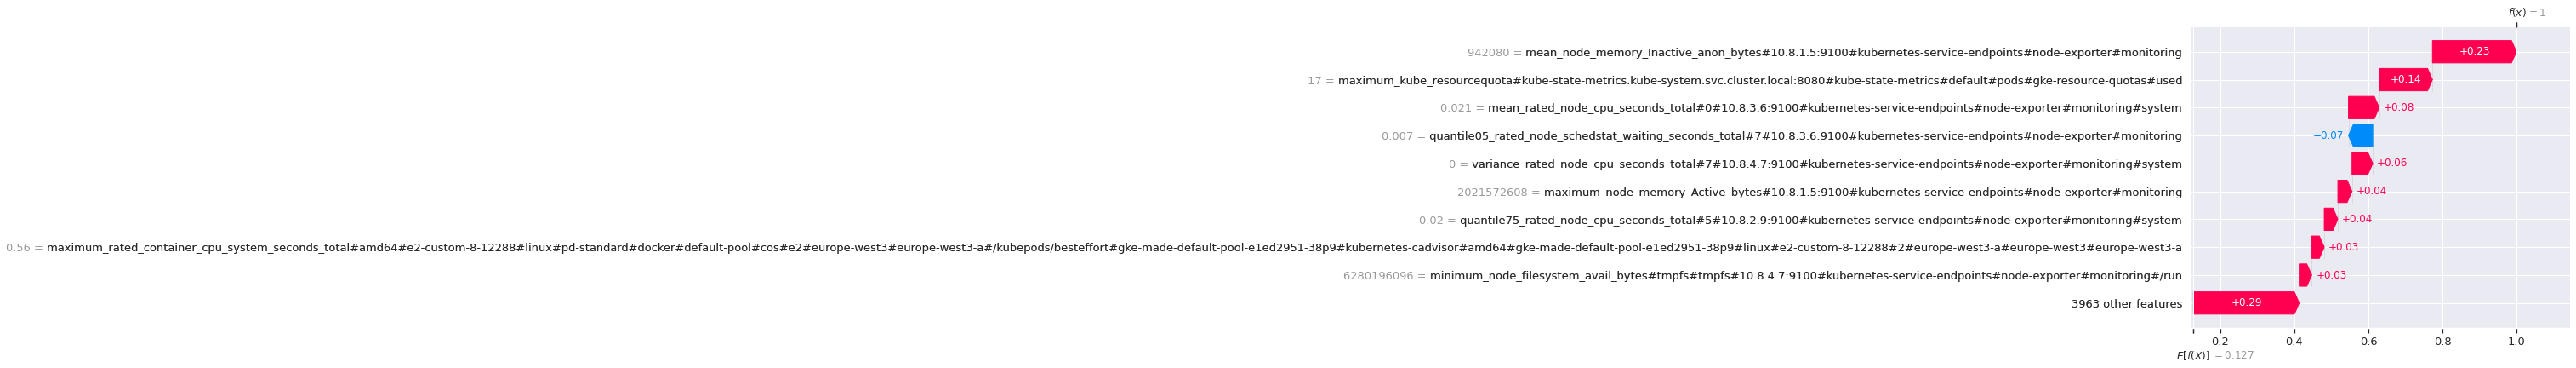

In [147]:
# Local interpretability for class 0 on instance 11.
with open('models/decision_tree/models/best_decision_tree.pkl', 'rb') as fid:
    dt_model = pickle.load(fid)

explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(x_test)

class_number = 0
row = 11

shap.waterfall_plot(shap.Explanation(values=shap_values[class_number][row],base_values=explainer.expected_value[0], data=x_test.iloc[row],  
                                         feature_names=x_test.columns.tolist()))

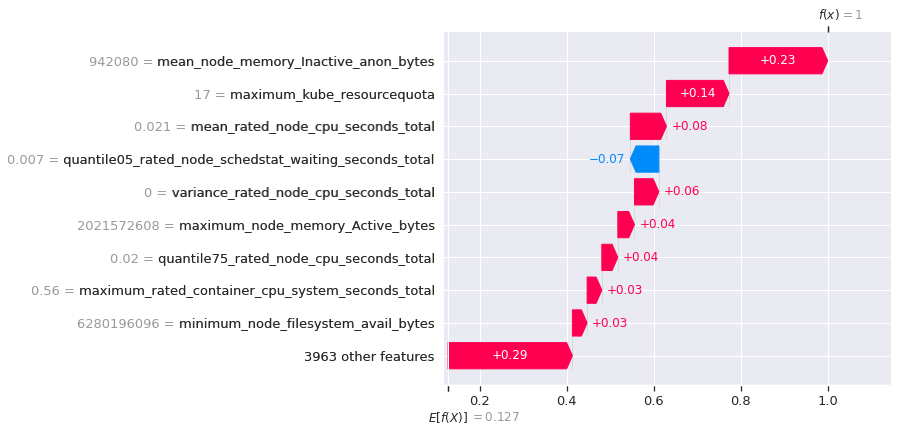

In [106]:
# Short name version.
class_number = 0
row = 11

shap.waterfall_plot(shap.Explanation(values=shap_values[class_number][row],base_values=explainer.expected_value[0], data=x_test.iloc[row],  
                                         feature_names=x_test.columns.tolist()))

## Random Forest: SHAP

<Figure size 1202.4x595.44 with 0 Axes>

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


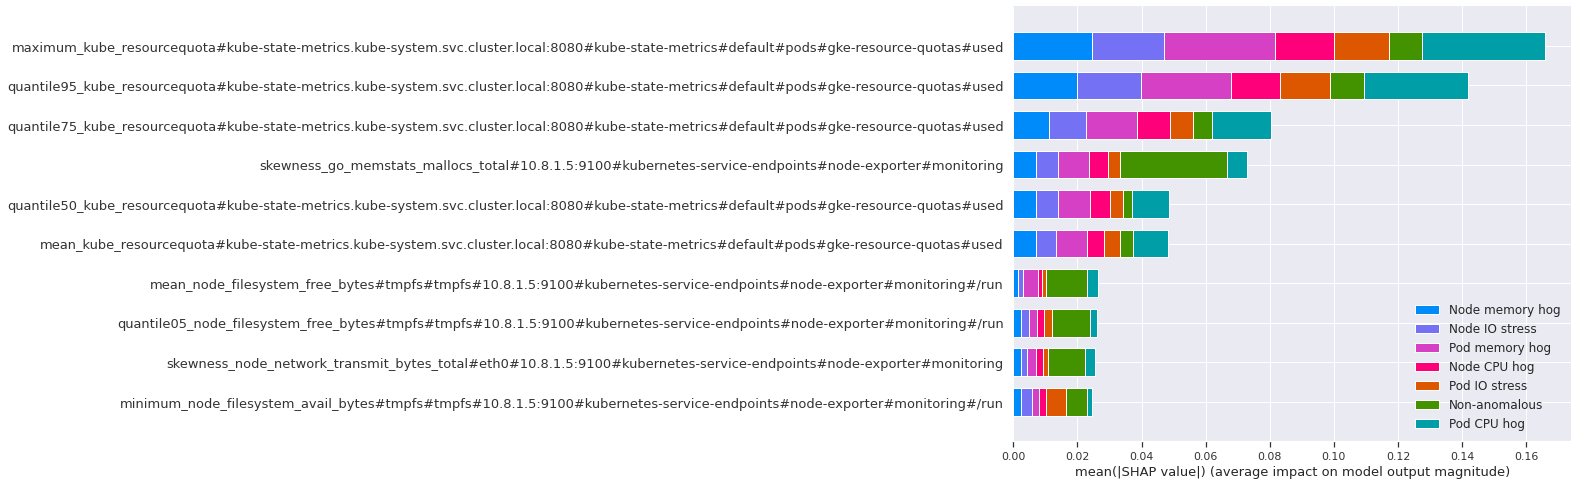

In [141]:
# Load best random forest
with open('models/random_forest/models/best_random_forest.pkl', 'rb') as fid:
    rf_model = pickle.load(fid)

figure = plt.figure()

# Show most important features and their importance to each class/anomaly
shap.initjs()

plt.figure(figsize=(14,8), tight_layout=True)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(x_test)

df_visual = x_test

shap.summary_plot(shap_values, df_visual, plot_type='bar', class_names = ['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], plot_size = (10, 8), max_display=10)


figure.savefig('visuals/RF_Global_Shap_Fullname.png', dpi=200)

plt.show()

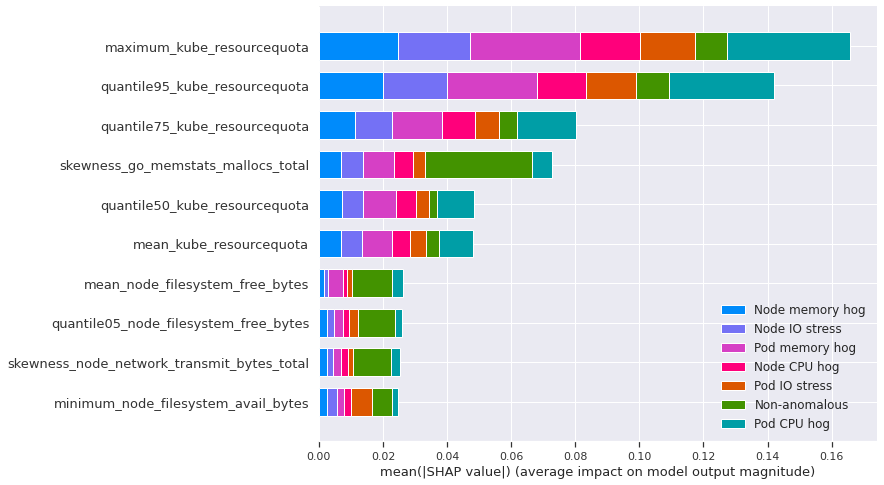

In [32]:
# Short name version
df_visual.columns = [column.split('#')[0] for column in x_test.columns]
shap.summary_plot(shap_values, df_visual, plot_type='bar', class_names = ['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'], plot_size = (10, 8), max_display=10)
figure.savefig('visuals/RF_Global_Shap_Shortname.png', dpi=200)

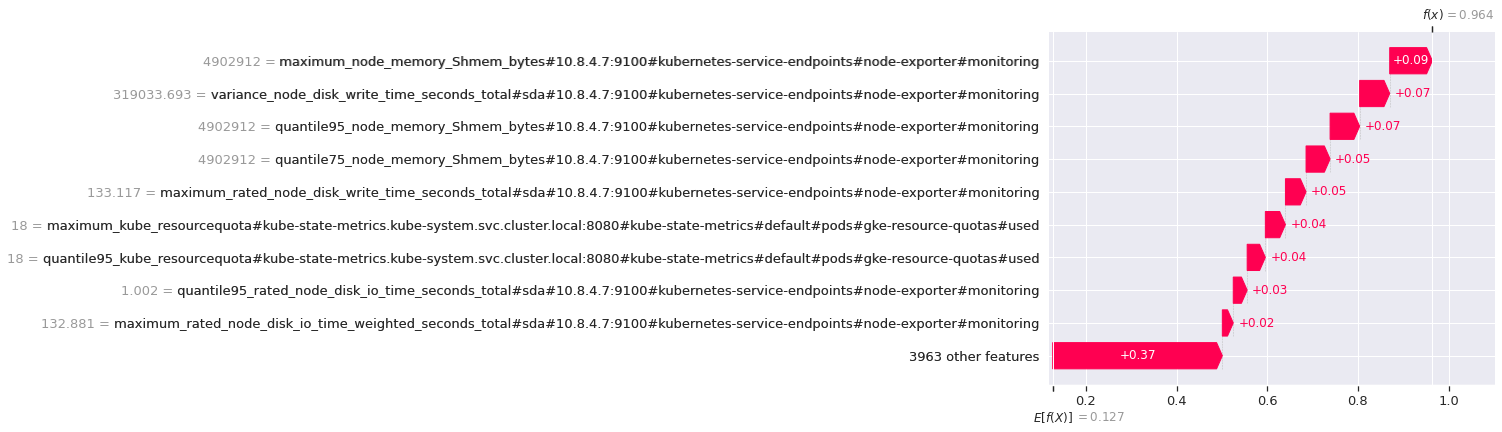

In [142]:
# Local interpretability for class 1 on instance 1.
class_number = 1
row = 1

shap.waterfall_plot(shap.Explanation(values=shap_values[class_number][row],base_values=explainer.expected_value[0], data=x_test.iloc[row],  
                                         feature_names=x_test.columns.tolist()))

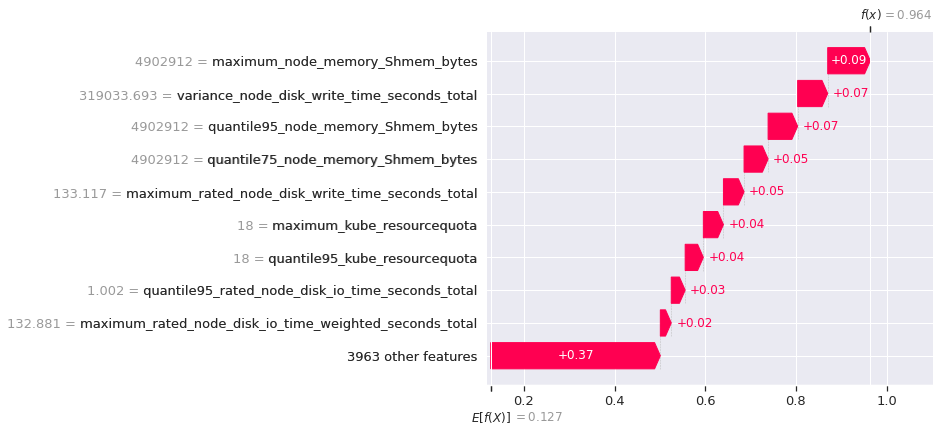

In [143]:
# Short name version.
df_visual.columns = [column.split('#')[0] for column in x_test.columns]
class_number = 1
row = 1

shap.waterfall_plot(shap.Explanation(values=shap_values[class_number][row],base_values=explainer.expected_value[0], data=x_test.iloc[row],  
                                         feature_names=x_test.columns.tolist()))

## AdaBoost: LIME

In [76]:
# Load best adaboost
with open('models/adaboost/models/best_dt_adaboost.pkl', 'rb') as fid:
    ada_model = pickle.load(fid)

filter_list = ['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] + [column for column in df.columns if 'scrape_series_added' in column] + [column for column in df.columns if 'prometheus_sd_kubernetes_events' in column] + [column for column in df.columns if 'goroutines' in column]

explainer = lime_tabular.LimeTabularExplainer(np.array(x_test), mode="classification",
                                              class_names=list(set(y_test)),
                                              feature_names=[column for column in x_test.columns if column not in filter_list], discretize_continuous=True)

explainer

In [77]:
explanation = explainer.explain_instance(np.array(x_test)[1], ada_model.predict_proba, top_labels=10)

In [78]:
explanation.show_in_notebook()

In [90]:
# Load best adaboost
with open('models/adaboost/models/best_dt_adaboost.pkl', 'rb') as fid:
    ada_model = pickle.load(fid)

filter_list = ['Anomaly_nr', 'Anomaly_name'] + [column for column in df.columns if 'scrape_samples' in column] + [column for column in df.columns if 'prometheus_tsdb_head_series' in column] + [column for column in df.columns if 'prometheus_tsdb_out_of_order' in column] + [column for column in df.columns if 'scrape_series_added' in column] + [column for column in df.columns if 'prometheus_sd_kubernetes_events' in column] + [column for column in df.columns if 'goroutines' in column]

explainer = lime_tabular.LimeTabularExplainer(np.array(x_test), mode="classification",
                                              class_names=['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous'],
                                              feature_names=[column for column in x_test.columns if column not in filter_list], discretize_continuous=True)

explainer

In [91]:
explanation = explainer.explain_instance(np.array(x_test)[1], ada_model.predict_proba, top_labels=10)

In [92]:
explanation.show_in_notebook()